# VAMP

For users already familiar with the VAMP interface: The corresponding [API docs](../api/generated/sktime.decomposition.VAMP.rst#sktime.decomposition.VAMP).

VAMP is short for [V]ariational [A]pproach for [M]arkov [P]rocesses and was introduced in <cite data-cite="wu2020variational">(Wu, 2020)</cite>. It can be used as linear dimensionality reduction tool and extends [TICA](tica.ipynb) in the sense that it gives rise to a systematic way to select input features as well as handles off-equilibrium data consistently.

While the VAMP model possesses methods to project data into lower dimensions, it also is equipped with scoring functions (the so-called VAMP scores), which allow ranking of features. This has been demonstrated in, e.g., <cite data-cite="scherer2019variational">(Scherer, 2019)</cite>.

In order to estimate a VAMP model, a Koopman operator $\mathcal{K}_\tau$ is estimated, which describes conditional future expectation values for a fixed lag time $\tau$. Its action on a function $g$ can be written as

$$ \mathcal{K}_\tau g(x) = \int p(y\mid x)(y) dy = \mathbb{E}[g(x_{t+\tau} | x_t = x) ],$$

where $p(y \mid x)$ is the conditional probability density that a point $y$ at time $t+\tau$ is visited given that point $x$ was visited at time $t$. Making the ansatz that $g$ is a linear combination $g = \sum_i w_i \chi_i$ for some basis functions $\chi_i$, the linear operator $\mathcal{K}_\tau$ can be expressed as matrix $K$. It can be shown <cite data-cite="wu2020variational">(Wu, 2020)</cite>, that the dominant eigenfunctions of an SVD of the Koopman operator in a whitenend basis $\bar K$ yields the best dynamical model for a given timeseries, which is also what is computed and projected on in estimator and model, respectively.

## Short API demonstration

To create a [VAMP estimator](../api/generated/sktime.decomposition.VAMP.rst#sktime.decomposition.VAMP), scikit-time needs to be imported...

In [1]:
import sktime

..., then the estimator can be found in the decomposition subpackage.

In [2]:
vamp_estimator = sktime.decomposition.VAMP(
    lagtime=1,  # the number of steps tau under which K is estimated
    dim=1  # projection dimension
)

One should note that the `dim` parameter can either be `None`, of type `int` or of type `float`:

- if `None`, all dimensions are kept,
- if of type `int` (and `>= 1`), this is the dimension to project onto,
- and if of type `float` (in the range $(0, 1]$), then this is interpreted as a percentage value which is the minimum threshold of kinetic variance that needs to be explained by the projection.

> Note that unless `None`, even setting the dimension with an integer might yield a lower-dimensional projection than the one requested if there is a rank deficit in the covariance matrices.

For demonstration purposes, we look at the Ellipsoids sample dataset, which is described in some detail in the example data's [documentation](../api/generated/impl/sktime.data.Ellipsoids.rst#sktime.data.Ellipsoids). In short, it is a two-dimensional process that has two metastable states in the form of nonoverlapping ellipsoids.

In [3]:
ellipsoids = sktime.data.ellipsoids(seed=17)  # create dataset instance with fixed seed for reproducibility
feature_trajectory = ellipsoids.observations(1000)  # 1000 observations
print(feature_trajectory.shape)

(1000, 2)


Given the data, all that is left to do is fitting a model and obtaining it from the estimator.

In [4]:
vamp_estimator.fit(feature_trajectory)
model = vamp_estimator.fetch_model();

The output dimension is set to `1`:

In [5]:
model.output_dimension

1

And the model can be scored, which evaluates how much "slowness" is captured with the current input features. Scores can **not** be compared across different lagtimes $\tau$.

In [6]:
model.score()

1.8493860426114919

Projecting the 2-dimensional data with the estimated VAMP model yields a 1-dimensional trajectory which clearly reveals the two-state metastable process which generated the data:

Projection shape: (1000, 1)



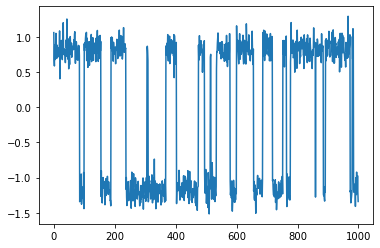

In [7]:
projection = model.transform(feature_trajectory)
print(f"Projection shape: {projection.shape}\n")

# plot projection
import matplotlib.pyplot as plt
plt.plot(projection);

## A more detailed look on the estimator

Here we follow the content presented in <cite data-cite="wu2020variational">(Wu, 2020)</cite> to give some more insight into the estimator. For a complete derivation and background please consult the source itself.

The VAMP estimator estimates a _linear_ model of the form

$$ \mathbb{E}[g(x_{t+\tau})] = K^\top \mathbb{E}[f(x_t)], $$

where $\tau > 0$ is the lagtime, $f(x) = (f_1(x),\ldots)^\top$ and $g(x) = (g_1(x),\ldots)^\top$ are feature transformations of the system's state $x$ at a point in time $t$ so that the dynamics are approximately linear.

While the matrix $K$ can in principle also be estimated using standard regression tools, the regression error gives no information about the choice of feature trasformations $f$ and $g$. When estimating $K$ using VAMP, a meaningful scoring and thus cross-validation is available. For details on the available scores, see the [Scoring](#Scoring) section.

This matrix is actually a finite-dimensional approximation of the Koopman operator

$$ \mathcal{K}_\tau g(x) = \mathbb{E}[g(x_{t+\tau} | x_t = x) ], $$

which maps for given $x_t$ to the expected value of an arbitrary observable $g$ at time $t+\tau$. This in particular means that the matrix $K$ depends on $\mathcal{K}_\tau$, i.e., models at different lagtimes approximate different operators and are thus not directly comparable.

One can show (Theorem 1 of <cite data-cite="wu2020variational">(Wu, 2020)</cite>), that the best approximation of $K$ to $\mathcal{K}_\tau$ is achieved for

$$ \bar K=\mathrm{diag}(\sigma_1,\ldots,\sigma_k), $$

when $f = (\psi_1,\ldots,\psi_k)$ and $g=(\phi_1,\ldots,\phi_k)$. Here $\sigma_i$, $\psi_i$, $\phi_i$ are the singular values, left singular functions, and right singular functions of $\mathcal{K}_\tau^*\mathcal{K}_\tau$, respectively. The $\psi_i$ and $\phi_i$ should form an orthonormal basis of respective spaces. In particular this means that in this representation,

$$ \mathbb{E}[\phi_i(x_{t+\tau})] = \sigma_i\mathbb{E}[\psi_i(x_t)] \text{ and } \bar{\mathcal{K}}_\tau g = \sum_i \sigma_i \langle g, \phi_i \rangle_{\rho_1} \psi_i, $$

where $\bar{\mathcal{K}}_\tau$ denotes the projected Koopman operator.

The [VAMP estimator](../api/generated/sktime.decomposition.VAMP.rst#sktime.decomposition.VAMP) first and foremost solves the following problem:

> Given a basis set $\chi^\top = (\chi_0^\top, \chi_1)^\top$ so that $f = U^\top \chi_0$ and $g=V^\top \chi_1$, find weights $U,V\in\mathbb{R}^{m\times k}$ so that the resulting linear model $\mathbb{E}[g(x_{t+\tau})] = K^\top \mathbb{E}[f(x_t)]$ is optimal.

To this end, (instantaneous and time-lagged) mean-free covariance matrices $C_{00}, C_{0t}, C_{tt}$ with

\begin{align*}
C_{00} &= \mathbb{E}_t[(\chi_0(x_t)-\mu_0)(\chi_0(x_t)-\mu_0)^\top], \\
C_{0t} &= \mathbb{E}_t[(\chi_0(x_t)-\mu_0)(\chi_1(x_{t+\tau})-\mu_1)^\top],\\
C_{tt} &= \mathbb{E}_t[(\chi_1(x_{t+\tau})-\mu_1)(\chi_1(x_{t+\tau})-\mu_1)^\top]
\end{align*}

are computed, see also the [Covariances estimator](../api/generated/sktime.covariance.Covariance.rst#sktime.covariance.Covariance). These covariance matrices can be accessed in the computed model:

In [8]:
print("mean_0 shape:", model.mean_0.shape)
print("mean_t shape:", model.mean_t.shape)
print("C00 shape:", model.cov_00.shape)
print("C0t shape:", model.cov_0t.shape)
print("Ctt shape:", model.cov_tt.shape)

mean_0 shape: (2,)
mean_t shape: (2,)
C00 shape: (2, 2)
C0t shape: (2, 2)
Ctt shape: (2, 2)


Based on these covariances, the truncated SVD

$$\bar K = C_{00}^{-1/2}C_{0t}C_{tt}^{-1/2} \approx U' \mathrm{diag}(\sigma_1,\ldots,\sigma_k) V' $$

is evaluated, where $\bar K$ is the Koopman matrix for normalized basis functions $C_{00}^{-1/2}\chi_0$ and $C_{tt}^{-1/2}\chi_1$, respectively. The truncation is based on the [dim](../api/generated/sktime.decomposition.VAMP.rst#sktime.decomposition.VAMP.dim) parameter of the estimator.

The sought-after weight matrices $U$ and $V$ are then given by

\begin{align*}
U &= C_{00}^{-1/2}U', \\
V &= C_{tt}^{-1/2}V',
\end{align*}

respectively. The singular values as well as $U$ and $V$ are accessible as:

In [9]:
print("singular values:", model.singular_values)
print("left singular vectors U:", model.singular_vectors_left)
print("right singular vectors V:", model.singular_vectors_right)

singular values: [0.92162142 0.02521945]
left singular vectors U: [[ 0.40047651]
 [-0.40008139]]
right singular vectors V: [[ 0.39598905]
 [-0.40009719]]


The resulting linear model 

$$ \mathbb{E}[g(x_{t+\tau})] = K^\top \mathbb{E}[f(x_t)] $$

is then given by $K = \mathrm{diag}(\sigma_1,\ldots,\sigma_k)$, $f_i = u_i^\top\chi_0$, and $g_i = v_i^\top\chi_1$.

The model's [transform(data, right=False)](../api/generated/sktime.decomposition.VAMPModel.rst#sktime.decomposition.VAMPModel.transform) gives access to $f$ and $g$:

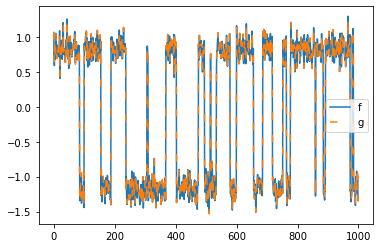

In [10]:
plt.plot(model.transform(feature_trajectory, right=False), label="f")
plt.plot(model.transform(feature_trajectory, right=True), linestyle=(0, (5, 10)), label="g")
plt.legend();

As one can observe, it makes no difference whether one projects $x_t \mapsto f(x_t)$ (forward in time) or $x_t\mapsto g(x_t)$ (backward in time). This is because the underlying process is time-reversible.

A consequence of this is that one should be aware of which data is provided into `transform`: Only 

- `feature_trajectory[:-tau, ...]` for `f` (i.e., `right=False`) and
- `feature_trajectory[tau:, ...]` for `g` (i.e., `right=True`)

contain valid values, the remainder might be interpreted as extrapolation.

## Scoring

While the estimator solves the problem of finding optimal transforms $f$, $g$, and $K$, one of the advantages of using the variational approach is that the models can be scored with respect to the choice of the system's featurization.

This makes it possible to not optimize for transforms given a basis but also for the basis itself. If -hyothetically- infinite data and computational power were avaiable, the best possible basis would be the one that can describe the full operator $\mathcal{K}_\tau$. In practice however, often a balance between the modeling/discretization error of approximating $\mathcal{K}_\tau$ and the statistical error of fitting the parameters given finite data has to be struck.

There are three different scores implement in scikit-time:

1. The VAMP-1 score, evaluating the sum of the singular values $s = \sum_i\sigma_i$ <cite data-cite="noe2013variational">(Noé, 2013)</cite> and <cite data-cite="mcgibbon2015variational">(McGibbon, 2015)</cite>:

In [11]:
model.score(score_method="VAMP1")

1.9216214204387243

2. The VAMP-2 score, evaluating the squared sum of the singular values $s = \sum_i \sigma_i^2$, which maximizes the kinetic variance captured by the model <cite data-cite="noe2015kinetic">(Noé, 2015)</cite>. It is also directly related to the approximation error to the true Koopman operator $\mathcal{K}_\tau$ <cite data-cite="wu2020variational">(Wu, 2020)</cite>. This is the default choice for scoring.

In [12]:
model.score(score_method="VAMP2")

1.8493860426114919

3. The VAMP-E score also relates to the approximation error to the true Koopman operator, however its computation is numerically more stable than VAMP-1 or VAMP-2, as it does not involve any matrix inversions <cite data-cite="wu2020variational">(Wu, 2020)</cite>.

In [13]:
model.score(score_method="VAMPE")

1.8493860426114912

In addition to the `score_method` parameter, there is also a `test_model` parameter. By default it is `None` and the score is evaluated as-is. In case it is not `None`, the `score()` method evaluates the cross-validation score between the current model and `test_model`.

> It is assumed that the model and the test_model stem from respective "training" and "testing" datasets. Estimation of the average cross-validation score and partitioning of data into test and training part is not performed by this method.

## Singular vector scaling

Optionally the singular vectors can be scaled upon projection. Per default, [scaling](../api/generated/sktime.decomposition.VAMP.rst#sktime.decomposition.VAMP.scaling) is set to `None` which means that no scaling is applied and the variance of all singular vectors (sometimes also called order parameters) is $1$.

In [14]:
print(vamp_estimator.scaling)

None


One has the option to set it to `"kinetic_map"`, which means that the singular vectors are scaled by their respective singular value. As a result, Euclidean distances in the "left singular vectors"-transformed data approximate kinetic distances with respect to the forward propagator. Vice versa, a kinetic map is induced when using scaled right singular vectors and the backward propagator.

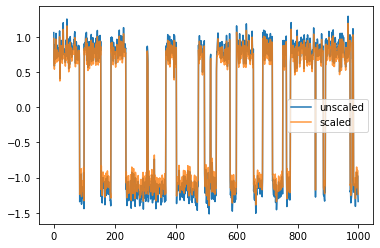

In [15]:
vamp_estimator.scaling = "kinetic_map"
scaled_model = vamp_estimator.fit(feature_trajectory).fetch_model()

# plotting transformations
plt.plot(model.transform(feature_trajectory, right=False), label="unscaled")
plt.plot(scaled_model.transform(feature_trajectory, right=False), alpha=.8, label="scaled")
plt.legend();

## Example with position based fluids

In [23]:
from sktime.data.pbf import PBF

In [24]:
interaction_distance = 1.5
init_pos_x = np.arange(-24, 24, interaction_distance*.9).astype(np.float32)
init_pos_y = np.arange(0, 24, interaction_distance*.9).astype(np.float32)
init_pos = np.dstack(np.meshgrid(init_pos_x, init_pos_y)).reshape(-1, 2)
n_particles = init_pos.shape[0]
domain = np.array([80, 50])
pbf = PBF(domain, init_pos, interaction_distance, 8)

In [25]:
n_burn_in = 5000

In [26]:
traj = pbf.run(n_burn_in, 0);

In [27]:
box_width = .7

In [28]:
def make_animation(trajectory, stride, mode="scatter"):
    traj = trajectory.reshape((len(trajectory), -1, 2))
    traj = traj[::stride]
    
    backend_ =  mpl.get_backend()
    mpl.use("Agg")  # Prevent showing stuff

    fig, ax = plt.subplots()
    ax.set_xlim((-domain[0]/2, domain[0]/2))
    ax.set_ylim((-domain[1]/2, domain[1]/2))

    s = np.empty((n_particles,))
    s.fill(300)
    c = np.empty((n_particles,))
    c.fill(0.5)
    
    # needed for contourf
    grid = None
    gridx = None
    gridy = None
    contour_handle = []
    
    if mode == "scatter":
        the_plot = ax.scatter(traj[0, :, 0], traj[0, :, 1], s=s, c=c, vmin=0, vmax=1, 
                              cmap="jet", edgecolor="k")
    elif mode == "contourf":
        gridx = np.arange(-domain[0]/2, domain[0]/2, box_width).astype(np.float32)
        gridy = np.arange(-domain[1]/2, domain[1]/2, box_width).astype(np.float32)
        grid = np.meshgrid(gridx, gridy)
        the_plot = ax.contourf(grid[0], grid[1], traj[0].reshape((len(gridy), len(gridx))))
        contour_handle.append(the_plot)
    
    def update_scatter(i):
        X = traj[i]
        the_plot.set_offsets(X)
        return the_plot,
        
    def update_contourf(i):
        X = traj[i]
        for tp in contour_handle[0].collections:
            tp.remove()
        contour_handle[0] = ax.contourf(grid[0], grid[1], X.reshape((len(gridy), len(gridx))))
        return contour_handle[0].collections
    
    update = update_scatter if mode == "scatter" else update_contourf
    ani = animation.FuncAnimation(fig, update, interval=50, blit=True, repeat=False, 
                                  frames=len(traj))

    mpl.use(backend_) # Reset backend
    return ani

In [29]:
from tqdm.notebook import tqdm

In [30]:
n_steps = 400
n_rounds = 40
drift = .3
traj_total = np.empty((n_rounds*n_steps, n_particles*2))
for i in tqdm(range(n_rounds)):
    traj = pbf.run(n_steps, drift if i % 2 != 0 else -drift);
    traj_total[i*n_steps:(i+1)*n_steps] = traj

In [31]:
ani = make_animation(traj_total, 30)
from IPython.display import HTML
HTML(ani.to_html5_video())

In [32]:
from scipy.stats import gaussian_kde
box_width = .7
traj = traj_total.reshape(len(traj_total), -1, 2)

In [33]:
import multiprocessing as mp

gridx = np.arange(-domain[0]/2, domain[0]/2, box_width).astype(np.float32)
gridy = np.arange(-domain[1]/2, domain[1]/2, box_width).astype(np.float32)
grid = np.meshgrid(gridx, gridy)
kde_input = np.dstack(grid).reshape(-1, 2)
traj_kde = np.empty((len(traj), len(kde_input)))

def worker(args):
    from scipy.stats import gaussian_kde
    t, traj = args[0], args[1]
    out = gaussian_kde(traj.T, bw_method=0.2).evaluate(kde_input.T)
    out /= out.sum()
    return t, out

with mp.Pool(processes=8) as pool:
    for result in tqdm(pool.imap_unordered(worker, zip(range(len(traj)), traj)), total=len(traj)):
        traj_kde[result[0]] = result[1]

In [34]:
ani = make_animation(traj_kde, 30, "contourf")
from IPython.display import HTML
HTML(ani.to_html5_video())

In [35]:
from sktime.data import timeshifted_split

In [36]:
len(traj_kde)

16000

In [ ]:
models = []
for tau in [1, 5, 10, 20, 30, 40, 50, 100, 150, 200, 250, 300, 350]:
    est = sktime.decomposition.VAMP(lagtime=tau, dim=.95)
    for X,Y in tqdm(timeshifted_split(traj_kde, lagtime=tau, chunksize=500, stride=1)):
        est.partial_fit((X, Y))
    models.append(est.fetch_model())

In [1]:
for tau, model in zip([1, 5, 10, 20, 30, 40, 50, 100, 150, 200, 250, 300, 350], models):
    print("---"*15, tau, "---"*15)
    print("dim:", model.output_dimension)
    print("score:", model.score())
    plt.plot(model.singular_values, '.')
    
    n_sing = 3

    f, axes = plt.subplots(ncols=2, nrows=3, figsize=(12, 20))
    for i in range(n_sing):
        ax = axes[i][0]
        im = model.singular_vectors_left[:, i].reshape((len(gridy), len(gridx)))
        # cb = ax.contourf(grid[0], grid[1], im)
        cb = ax.imshow(im, origin="lower", cmap="bwr")
        f.colorbar(cb, ax=ax)
        ax.set_title("left eigenfunction {}".format(i))

        ax = axes[i][1]
        im = model.singular_vectors_right[:, i].reshape((len(gridy), len(gridx)))
        cb = ax.imshow(im, origin="lower", cmap="bwr")
        f.colorbar(cb, ax=ax)
        ax.set_title("right eigenfunction {}".format(i))
        
    plt.show()

NameError: name 'models' is not defined

In [ ]:
models = []
for tau in [31, 32, 33, 34, 35, 36, 37, 38, 39, 40]:
    est = sktime.decomposition.VAMP(lagtime=tau, dim=.95)
    for X,Y in tqdm(timeshifted_split(traj_kde, lagtime=tau, chunksize=500, stride=1)):
        est.partial_fit((X, Y))
    models.append(est.fetch_model())

In [ ]:
for tau, model in zip([31, 32, 33, 34, 35, 36, 37, 38, 39, 40], models):
    print("---"*15, tau, "---"*15)
    print("dim:", model.output_dimension)
    print("score:", model.score())
    plt.plot(model.singular_values, '.')
    
    n_sing = 3

    f, axes = plt.subplots(ncols=2, nrows=3, figsize=(12, 20))
    for i in range(n_sing):
        ax = axes[i][0]
        im = model.singular_vectors_left[:, i].reshape((len(gridy), len(gridx)))
        # cb = ax.contourf(grid[0], grid[1], im)
        cb = ax.imshow(im, origin="lower", cmap="bwr")
        f.colorbar(cb, ax=ax)
        ax.set_title("left eigenfunction {}".format(i))

        ax = axes[i][1]
        im = model.singular_vectors_right[:, i].reshape((len(gridy), len(gridx)))
        cb = ax.imshow(im, origin="lower", cmap="bwr")
        f.colorbar(cb, ax=ax)
        ax.set_title("right eigenfunction {}".format(i))
        
    plt.show()